In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [ ]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data') 

In [ ]:
labels = os.listdir(data_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_data = []
labels_data = []
for label in labels:
    for filename in os.listdir(data_dir + '/' + label ):
        files_data.append(data_dir + '/' + label + '/' + filename)
        labels_data.append(label)

In [ ]:
labels

['Non_violation', 'Violation']

In [ ]:
print("The first five files from the list of train images:", files_data[:5])
print("\nThe first five labels from the list of train labels:", labels_data[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_2_2994144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/Copy of _6_5523581.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_0_5482144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_4_27430.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_11_1737337.jpg']

The first five labels from the list of train labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']


In [ ]:
print(len(labels_data))

1289


In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

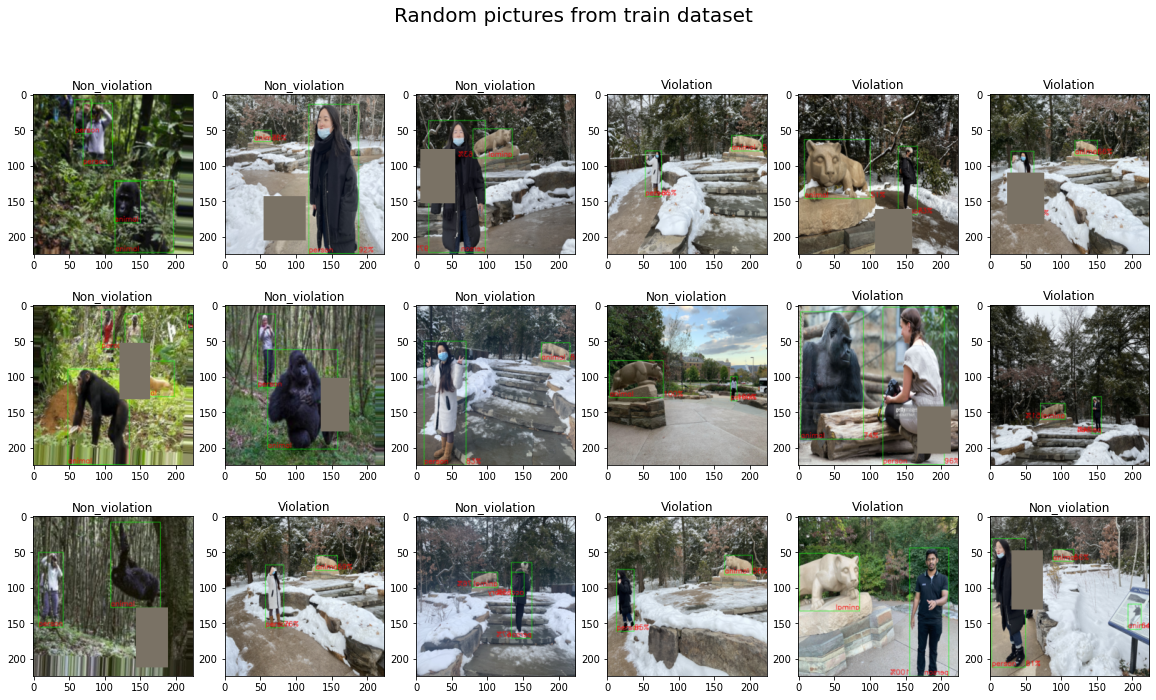

In [ ]:

dataset = ImagesDataset(files=files_data,
                              labels=labels_data,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')



fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(dataset))
    img = dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([dataset[n][1]])[0])
    ax.imshow(img)

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [900, 289, 100])

In [ ]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

900 289 100


In [ ]:
labels_test = []
for i in range(len(test_dataset)):
  labels_test.append(encoder_labels.inverse_transform([test_dataset[i][1]])[0])

In [ ]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [ ]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.007)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
num_epochs = 35

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:42<23:49, 42.06s/it]

	| New lowest val loss for DenseNet161: 0.022216504214131707
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:23<22:57, 41.73s/it]

	| New lowest val loss for DenseNet161: 0.018958886601933147
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [02:04<22:05, 41.43s/it]

Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:46<21:24, 41.43s/it]

	| New lowest val loss for DenseNet161: 0.016272005119125736
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:27<20:43, 41.45s/it]

	| New lowest val loss for DenseNet161: 0.015299968137873085
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [04:09<20:03, 41.51s/it]

	| New lowest val loss for DenseNet161: 0.01459900782182555
Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:50<19:18, 41.38s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [05:31<18:34, 41.28s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [06:12<17:49, 41.13s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:53<17:08, 41.12s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [07:34<16:25, 41.07s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [08:15<15:43, 41.03s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [08:56<15:03, 41.07s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [09:37<14:25, 41.23s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [10:19<13:47, 41.36s/it]

	| New lowest val loss for DenseNet161: 0.014455899647775406
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [11:01<13:07, 41.44s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [11:42<12:25, 41.41s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [12:23<11:43, 41.39s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [13:05<11:02, 41.38s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [13:46<10:20, 41.37s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [14:28<09:39, 41.42s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [15:09<08:59, 41.52s/it]

	| New lowest val loss for DenseNet161: 0.013907548981141878
Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [15:51<08:17, 41.49s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [16:32<07:35, 41.44s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [17:13<06:54, 41.41s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [17:55<06:12, 41.41s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [18:37<05:32, 41.56s/it]

	| New lowest val loss for DenseNet161: 0.013698693274626682
Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [19:18<04:51, 41.60s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [20:00<04:09, 41.66s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [20:42<03:27, 41.57s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [21:23<02:46, 41.55s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [22:05<02:04, 41.51s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [22:46<01:22, 41.42s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [23:27<00:41, 41.34s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [24:08<00:00, 41.39s/it]


Training complete in 24m 9s


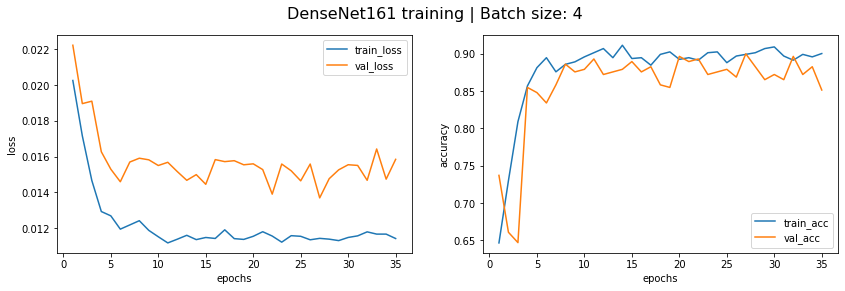


Training results:
	Min val loss 0.0137 was achieved during epoch #27
	Val accuracy during min val loss is 0.8997


In [ ]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:37<21:08, 37.32s/it]

	| New lowest val loss for ResNet50: 0.0428688429218675
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:14<20:32, 37.35s/it]

	| New lowest val loss for ResNet50: 0.019464166828505308
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [01:51<19:53, 37.29s/it]

Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:29<19:15, 37.27s/it]

	| New lowest val loss for ResNet50: 0.016716011255257682
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:06<18:37, 37.25s/it]

Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [03:43<17:59, 37.23s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:20<17:20, 37.14s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [04:57<16:40, 37.05s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [05:34<16:03, 37.05s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:11<15:28, 37.13s/it]

	| New lowest val loss for ResNet50: 0.01566094644754403
Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [06:48<14:50, 37.12s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [07:26<14:14, 37.17s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [08:03<13:36, 37.11s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [08:39<12:57, 37.03s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [09:16<12:20, 37.01s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [09:53<11:42, 36.99s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [10:30<11:06, 37.00s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [11:08<10:31, 37.12s/it]

	| New lowest val loss for ResNet50: 0.015143777878639195
Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [11:45<09:54, 37.15s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [12:22<09:16, 37.12s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [12:59<08:39, 37.09s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [13:36<08:01, 37.07s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [14:13<07:24, 37.07s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [14:50<06:48, 37.10s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [15:27<06:10, 37.07s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [16:04<05:33, 37.06s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [16:41<04:56, 37.01s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [17:18<04:18, 36.94s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [17:55<03:42, 37.02s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [18:32<03:04, 36.98s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [19:09<02:27, 36.96s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [19:46<01:50, 36.92s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [20:23<01:14, 37.02s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [21:00<00:37, 37.08s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [21:37<00:00, 37.08s/it]


Training complete in 21m 38s


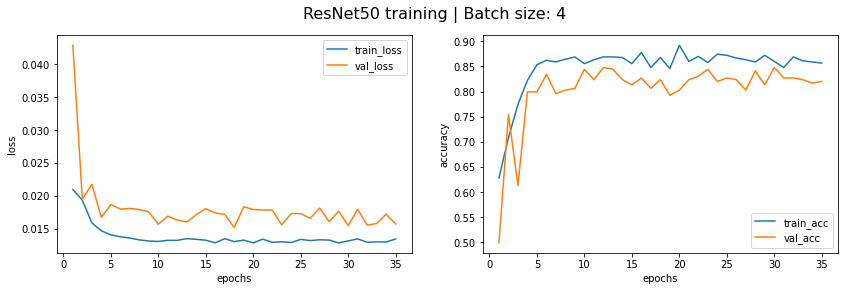


Training results:
	Min val loss 0.0151 was achieved during epoch #18
	Val accuracy during min val loss is 0.8235


In [ ]:
model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)

resnet50_training_results = training(model=model_resnet50,
                                      model_name='ResNet50',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet50, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet50_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet50",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:41<23:39, 41.74s/it]

	| New lowest val loss for ResNet152: 0.02995568024039681
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:23<23:00, 41.84s/it]

	| New lowest val loss for ResNet152: 0.029103963020351106
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [02:05<22:20, 41.88s/it]

	| New lowest val loss for ResNet152: 0.02753026963930229
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:47<21:37, 41.85s/it]

	| New lowest val loss for ResNet152: 0.015831218768156113
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:28<20:52, 41.76s/it]

Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [04:10<20:05, 41.57s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:51<19:22, 41.51s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [05:33<18:43, 41.62s/it]

	| New lowest val loss for ResNet152: 0.015790989345332743
Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [06:15<18:05, 41.73s/it]

	| New lowest val loss for ResNet152: 0.01564161556814781
Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:57<17:25, 41.82s/it]

	| New lowest val loss for ResNet152: 0.015128295623719899
Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [07:38<16:40, 41.69s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [08:20<15:56, 41.59s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [09:01<15:13, 41.51s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [09:42<14:29, 41.40s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [10:23<13:46, 41.31s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [11:05<13:05, 41.36s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [11:47<12:27, 41.53s/it]

	| New lowest val loss for ResNet152: 0.014898273668487179
Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [12:28<11:44, 41.46s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [13:09<11:01, 41.35s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [13:50<10:20, 41.37s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [14:32<09:39, 41.39s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [15:14<09:00, 41.55s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [15:56<08:19, 41.61s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [16:37<07:36, 41.54s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [17:18<06:54, 41.48s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [18:00<06:14, 41.57s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [18:41<05:31, 41.48s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [19:23<04:50, 41.44s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [20:04<04:08, 41.45s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [20:46<03:27, 41.41s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [21:27<02:45, 41.43s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [22:09<02:04, 41.48s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [22:50<01:22, 41.45s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [23:32<00:41, 41.49s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [24:13<00:00, 41.53s/it]


Training complete in 24m 14s


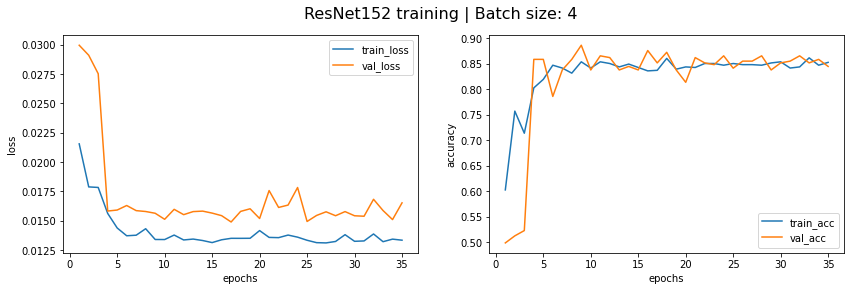


Training results:
	Min val loss 0.0149 was achieved during epoch #17
	Val accuracy during min val loss is 0.8512


In [ ]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:41<23:16, 41.06s/it]

	| New lowest val loss for VGG16: 0.01963765779993526
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:22<22:38, 41.17s/it]

	| New lowest val loss for VGG16: 0.01592532449940084
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [02:01<21:25, 40.18s/it]

Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:42<20:54, 40.48s/it]

	| New lowest val loss for VGG16: 0.014642879418435806
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:23<20:24, 40.82s/it]

	| New lowest val loss for VGG16: 0.013591198618024278
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [04:04<19:46, 40.92s/it]

	| New lowest val loss for VGG16: 0.012853084241642672
Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:44<18:51, 40.41s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [05:23<17:58, 39.93s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [06:04<17:26, 40.26s/it]

	| New lowest val loss for VGG16: 0.012480527317235214
Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:42<16:36, 39.86s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [07:21<15:49, 39.56s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [08:01<15:08, 39.49s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [08:40<14:25, 39.36s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [09:19<13:44, 39.25s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [09:58<13:03, 39.20s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [10:39<12:36, 39.80s/it]

	| New lowest val loss for VGG16: 0.012303383962918317
Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [11:18<11:52, 39.59s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [11:57<11:09, 39.36s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [12:36<10:28, 39.25s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [13:15<09:49, 39.27s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [13:54<09:09, 39.24s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [14:33<08:28, 39.15s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [15:13<07:50, 39.17s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [15:52<07:10, 39.12s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [16:31<06:31, 39.12s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [17:10<05:51, 39.09s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [17:49<05:12, 39.10s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [18:28<04:34, 39.15s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [19:08<03:55, 39.23s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [19:49<03:19, 39.86s/it]

	| New lowest val loss for VGG16: 0.01172148005772627
Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [20:29<02:39, 39.85s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [21:08<01:58, 39.63s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [21:47<01:19, 39.50s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [22:26<00:39, 39.41s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [23:06<00:00, 39.61s/it]


Training complete in 23m 6s


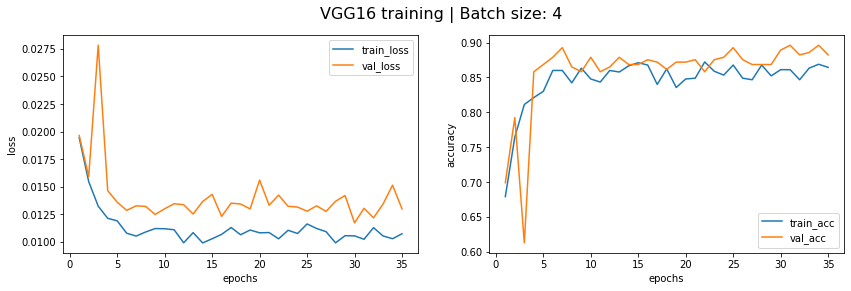


Training results:
	Min val loss 0.0117 was achieved during epoch #30
	Val accuracy during min val loss is 0.8893


In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)

vgg16_training_results = training(model=model_vgg16,
                                     model_name='VGG16',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg16, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg16_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG16",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:42<24:14, 42.78s/it]

	| New lowest val loss for VGG19_bn: 0.01887660538036518
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:23<22:51, 41.56s/it]

Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [02:06<22:31, 42.23s/it]

	| New lowest val loss for VGG19_bn: 0.015458276733807626
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:49<21:54, 42.40s/it]

	| New lowest val loss for VGG19_bn: 0.014384238055833071
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:31<21:14, 42.47s/it]

	| New lowest val loss for VGG19_bn: 0.01370023299253523
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [04:12<20:12, 41.83s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:52<19:15, 41.28s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [05:32<18:27, 41.02s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [06:13<17:42, 40.86s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:54<16:59, 40.79s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [07:34<16:17, 40.74s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [08:15<15:38, 40.81s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [08:58<15:13, 41.50s/it]

	| New lowest val loss for VGG19_bn: 0.01289440067581652
Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [09:39<14:29, 41.40s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [10:21<13:46, 41.30s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [11:02<13:03, 41.26s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [11:43<12:22, 41.24s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [12:24<11:40, 41.18s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [13:05<10:58, 41.13s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [13:46<10:16, 41.08s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [14:27<09:33, 40.98s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [15:08<08:53, 41.02s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [15:49<08:12, 41.02s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [16:30<07:30, 40.99s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [17:11<06:50, 41.01s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [17:52<06:08, 40.96s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [18:33<05:28, 41.03s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [19:14<04:47, 41.04s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [19:55<04:06, 41.03s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [20:36<03:25, 41.01s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [21:17<02:43, 40.96s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [21:58<02:02, 40.92s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [22:38<01:21, 40.92s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [23:19<00:40, 40.95s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [24:01<00:00, 41.17s/it]


Training complete in 24m 1s


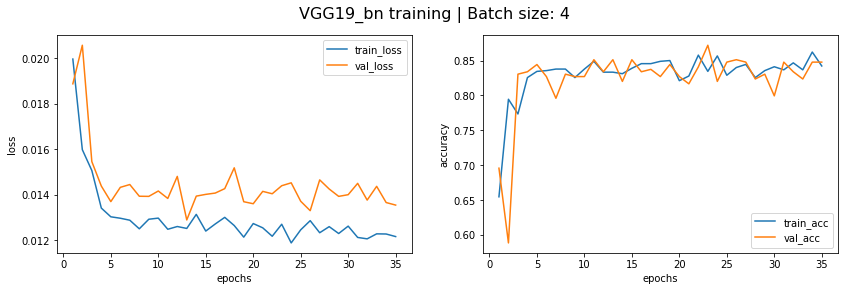


Training results:
	Min val loss 0.0129 was achieved during epoch #13
	Val accuracy during min val loss is 0.8512


In [ ]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE
        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [01:14<29:53, 74.71s/it]

	| New lowest val loss for Ensemble: 0.015644369343985325
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [02:30<28:56, 75.50s/it]

	| New lowest val loss for Ensemble: 0.014702585329233981
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [03:45<27:37, 75.33s/it]

	| New lowest val loss for Ensemble: 0.014013446687002083
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [04:55<25:30, 72.90s/it]

Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [06:03<23:47, 71.39s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [07:18<22:58, 72.56s/it]

	| New lowest val loss for Ensemble: 0.01394148665934698
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [08:34<22:04, 73.58s/it]

	| New lowest val loss for Ensemble: 0.013542675229504858
Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [09:43<20:25, 72.09s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [10:58<19:28, 73.05s/it]

	| New lowest val loss for Ensemble: 0.011981132121234616
Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [12:07<17:56, 71.76s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [13:15<16:31, 70.82s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [14:24<15:12, 70.17s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [15:33<13:57, 69.80s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [16:42<12:45, 69.56s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [17:57<11:51, 71.18s/it]

	| New lowest val loss for Ensemble: 0.011973135920956885
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [19:07<10:36, 70.71s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [20:16<09:21, 70.18s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [21:24<08:08, 69.74s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [22:33<06:56, 69.48s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [23:42<05:46, 69.26s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [24:51<04:36, 69.10s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [26:00<03:27, 69.04s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [27:14<02:21, 70.78s/it]

	| New lowest val loss for Ensemble: 0.011511657631933483
Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [28:21<01:09, 69.67s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [29:28<00:00, 70.74s/it]


Training complete in 29m 28s


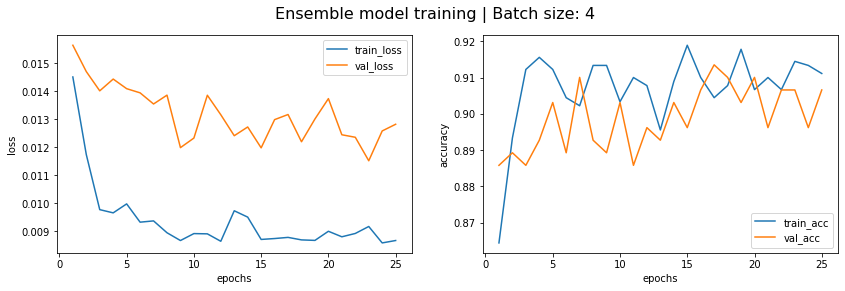


Training results:
	Min val loss 0.0115 was achieved during iteration #23
	Val accuracy during min val loss is 0.9066


In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=25,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=25,
                           model_name="Ensemble model",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_preds_decoded = encoder_labels.inverse_transform(all_preds)


100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


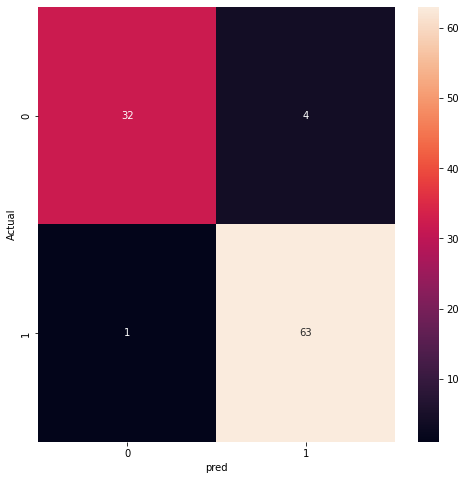

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.97      0.89      0.93        36
    Violation       0.94      0.98      0.96        64

     accuracy                           0.95       100
    macro avg       0.95      0.94      0.94       100
 weighted avg       0.95      0.95      0.95       100



In [ ]:
# print("Our model: \n\n", ensemble_model, '\n')
# print("The state dict keys: \n\n", ensemble_model.state_dict().keys())

In [ ]:
model_save_name = 'ensembleclassifier4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(ensemble_model.state_dict(), path)

In [ ]:
model_save_name = 'ensembleclassifier4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
ensemble_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# ensemble_model.eval()

In [ ]:
# import matplotlib.pyplot as plt

# import torch
# from torch import nn
# from torch import optim
# import torch.nn.functional as F
# from torchvision import datasets, transforms

# # upload external file before import
# from google.colab import files
# files.upload()
# import helper

# files.upload()
# import fc_model

In [ ]:
torch.save(ensemble_model.state_dict(), 'checkpoint_ensemble4.pth')

# download checkpoint file
# ensemble_model.download('checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint_ensemble4.pth')
print(state_dict.keys())

odict_keys(['modelA.features.conv0.weight', 'modelA.features.norm0.weight', 'modelA.features.norm0.bias', 'modelA.features.norm0.running_mean', 'modelA.features.norm0.running_var', 'modelA.features.norm0.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.norm1.weight', 'modelA.features.denseblock1.denselayer1.norm1.bias', 'modelA.features.denseblock1.denselayer1.norm1.running_mean', 'modelA.features.denseblock1.denselayer1.norm1.running_var', 'modelA.features.denseblock1.denselayer1.norm1.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.conv1.weight', 'modelA.features.denseblock1.denselayer1.norm2.weight', 'modelA.features.denseblock1.denselayer1.norm2.bias', 'modelA.features.denseblock1.denselayer1.norm2.running_mean', 'modelA.features.denseblock1.denselayer1.norm2.running_var', 'modelA.features.denseblock1.denselayer1.norm2.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.conv2.weight', 'modelA.features.denseblock1.denselayer2.norm1.weight', 'm

In [ ]:
ensemble_model.load_state_dict(state_dict)

<All keys matched successfully>

test on other data

In [ ]:
test2_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing')
test3_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation') 

In [ ]:
test4_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/other_animals')
test5_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/human_human')

In [ ]:
# List of files for testing
files_test2 = []
labels_test2 = []
for label in labels:
  for filename in os.listdir(test2_dir + '/' + label):
      files_test2.append(test2_dir + '/' + label + '/' + filename)
      files_test2 = sorted(files_test2)
      labels_test2.append(label)

files_test3 = []
labels_test3 = []
for label in labels:
  for filename in os.listdir(test3_dir + '/' + label):
      files_test3.append(test3_dir + '/' + label + '/' + filename)
      files_test3 = sorted(files_test3)
      labels_test3.append(label)
files_test4 = []
labels_test4 = []
for label in labels:
  for filename in os.listdir(test4_dir + '/' + label):
      files_test4.append(test4_dir + '/' + label + '/' + filename)
      files_test4 = sorted(files_test4)
      labels_test4.append(label)

files_test5 = []
labels_test5 = []
for label in labels:
  for filename in os.listdir(test5_dir + '/' + label):
      files_test5.append(test5_dir + '/' + label + '/' + filename)
      files_test5 = sorted(files_test5)
      labels_test5.append(label)

In [ ]:
print("\nThe first five files from the list of test images:", files_test2[:5])
print("\nThe first five labels from the list of test labels:", labels_test2[:5])
print("\nThe first five files from the list of test images:", files_test3[:5])
print("\nThe first five labels from the list of test labels:", labels_test3[:5])
print("\nThe first five files from the list of test images:", files_test4[:5])
print("\nThe first five labels from the list of test labels:", labels_test4[:5])
print("\nThe first five files from the list of test images:", files_test5[:5])
print("\nThe first five labels from the list of test labels:", labels_test5[:5])


The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2532090.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2857314.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_4326839.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_6340112.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _2_1274240.jpg']

The first five labels from the list of test labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']

The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation/Non_violation/IMG_1736.JPG', '/content/gdrive/MyDrive/GTVD

In [ ]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [ ]:
test_dataset2 = ImagesDataset(files=files_test2,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset3 = ImagesDataset(files=files_test3,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset4 = ImagesDataset(files=files_test4,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset5 = ImagesDataset(files=files_test5,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

In [ ]:
print(len(test_dataset2),len(test_dataset3), len(test_dataset4),len(test_dataset5))

48 142 78 16


In [ ]:
test_dataloader2 = DataLoader(test_dataset2, batch_size=8, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=20, shuffle=False)
test_dataloader4 = DataLoader(test_dataset4, batch_size=16, shuffle=False)
test_dataloader5 = DataLoader(test_dataset5, batch_size=4, shuffle=False)

In [ ]:
all_preds2 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader2):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds2.extend(preds.tolist())

all_preds_decoded2 = encoder_labels.inverse_transform(all_preds2)


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


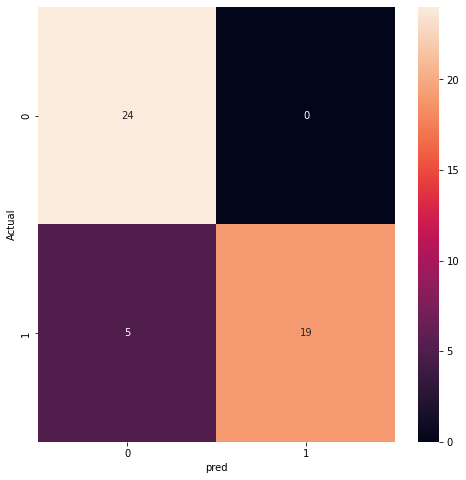

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test2, all_preds_decoded2)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test2, all_preds_decoded2,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.83      1.00      0.91        24
    Violation       1.00      0.79      0.88        24

     accuracy                           0.90        48
    macro avg       0.91      0.90      0.89        48
 weighted avg       0.91      0.90      0.89        48



In [ ]:
all_preds3 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader3):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds3.extend(preds.tolist())

all_preds_decoded3 = encoder_labels.inverse_transform(all_preds3)

100%|██████████| 8/8 [00:41<00:00,  5.23s/it]


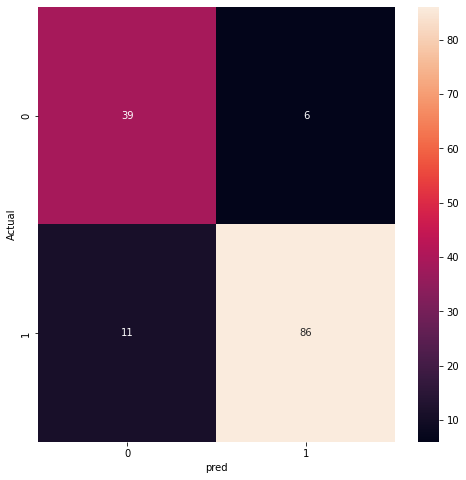

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test3, all_preds_decoded3)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test3, all_preds_decoded3,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.78      0.87      0.82        45
    Violation       0.93      0.89      0.91        97

     accuracy                           0.88       142
    macro avg       0.86      0.88      0.87       142
 weighted avg       0.89      0.88      0.88       142



In [ ]:
all_preds4 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader4):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds4.extend(preds.tolist())

all_preds_decoded4 = encoder_labels.inverse_transform(all_preds4)

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


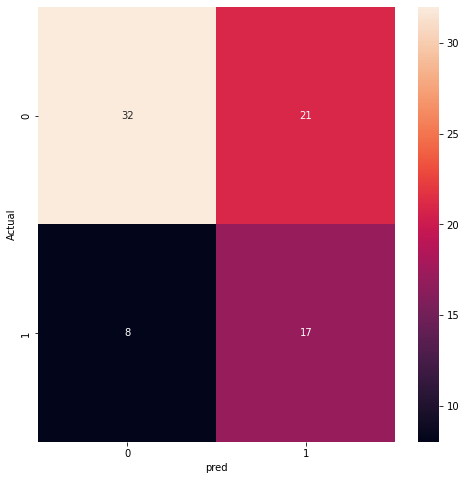

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test4, all_preds_decoded4)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
matrix = classification_report(labels_test4, all_preds_decoded4,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.80      0.60      0.69        53
    Violation       0.45      0.68      0.54        25

     accuracy                           0.63        78
    macro avg       0.62      0.64      0.61        78
 weighted avg       0.69      0.63      0.64        78



In [ ]:
all_preds5 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader5):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds5.extend(preds.tolist())

all_preds_decoded5 = encoder_labels.inverse_transform(all_preds5)

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


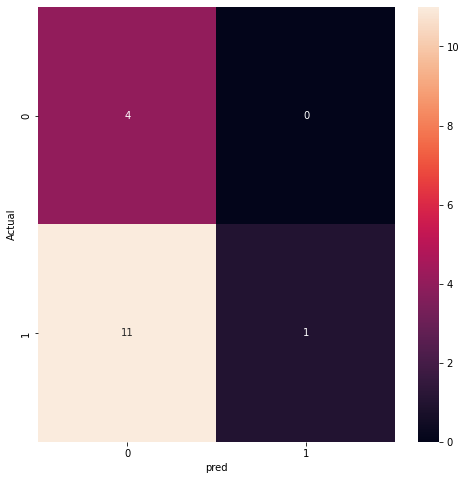

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test5, all_preds_decoded5)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
matrix = classification_report(labels_test5, all_preds_decoded5,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.27      1.00      0.42         4
    Violation       1.00      0.08      0.15        12

     accuracy                           0.31        16
    macro avg       0.63      0.54      0.29        16
 weighted avg       0.82      0.31      0.22        16



In [ ]:
!ls 

checkpoint_ensemble4.pth  gdrive		 sample_data
DenseNet161_weights.pth   ResNet152_weights.pth  VGG16_weights.pth
Ensemble_weights.pth	  ResNet50_weights.pth	 VGG19_bn_weights.pth


In [ ]:
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/ensemble_MixedData_v2

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v2.ipynb to html
[NbConvertApp] Writing 2420398 bytes to /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v2.html
